In [1]:
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    MeshcatVisualizer,
    Parser,
    Simulator,
    StartMeshcat,
    MultibodyPlant,
    InverseDynamicsController,
    Diagram,
    LeafSystem,
    Integrator,
    JacobianWrtVariable
)
import numpy as np
from manipulation.utils import RenderDiagram

In [2]:
meshcat = StartMeshcat()
running_as_notebook = True


INFO:drake:Meshcat listening for connections at http://localhost:7002


In [3]:
plant = MultibodyPlant(time_step=1e-2)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant).AddModelsFromUrl(
        "file:///Users/raghav/Documents/projects/robot_arm/low_cost_robot/drake_setup/low-cost-arm.urdf"
)
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"))
plant.Finalize()

In [4]:
context = plant.CreateDefaultContext()
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     10 states
       0 0 0 0 0 0 0 0 0 0

Parameters:
  28 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
          0.06752363433035656 -1.619616502021346e-05    0.04676572591178276    0.01444962435563458   0.002988209939972042  0.0007715578234369583   0.003060801516819979   7.57425414157306e-07  2.340285005439532e-07 -0.0008090338367206758
     10 parameters
          0.05066975917818724   0.001121533552091503   -0.01196009

In [7]:
plant.SetPositions(context, [1,1,1,1,1])
plant.GetJointByName("Revolute 2").set_angle(context, 2)
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     10 states
       2 1 1 1 1 0 0 0 0 0

Parameters:
  28 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
          0.06752363433035656 -1.619616502021346e-05    0.04676572591178276    0.01444962435563458   0.002988209939972042  0.0007715578234369583   0.003060801516819979   7.57425414157306e-07  2.340285005439532e-07 -0.0008090338367206758
     10 parameters
          0.05066975917818724   0.001121533552091503   -0.01196009

In [8]:
# plant.get_actuation_input_port().FixValue(context, np.zeros(5))
input_port = plant.get_geometry_query_input_port()

In [9]:
simulator = Simulator(plant, context)
simulator.AdvanceTo(5.0)
print(context)

::_ Context
------------
Time: 5
States:
  1 discrete state groups with
     10 states
       nan nan nan nan nan nan nan nan nan   0

Parameters:
  28 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
          0.06752363433035656 -1.619616502021346e-05    0.04676572591178276    0.01444962435563458   0.002988209939972042  0.0007715578234369583   0.003060801516819979   7.57425414157306e-07  2.340285005439532e-07 -0.0008090338367206758
     10 parameters
          0.05066975917818724   0.001121533552

In [10]:
meshcat.Delete()
meshcat.DeleteAddedControls()
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelsFromUrl(
     "file:///Users/raghav/Documents/projects/robot_arm/low_cost_robot/drake_setup/low-cost-arm.urdf"
)
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("plant and scene_graph")


In [11]:
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)

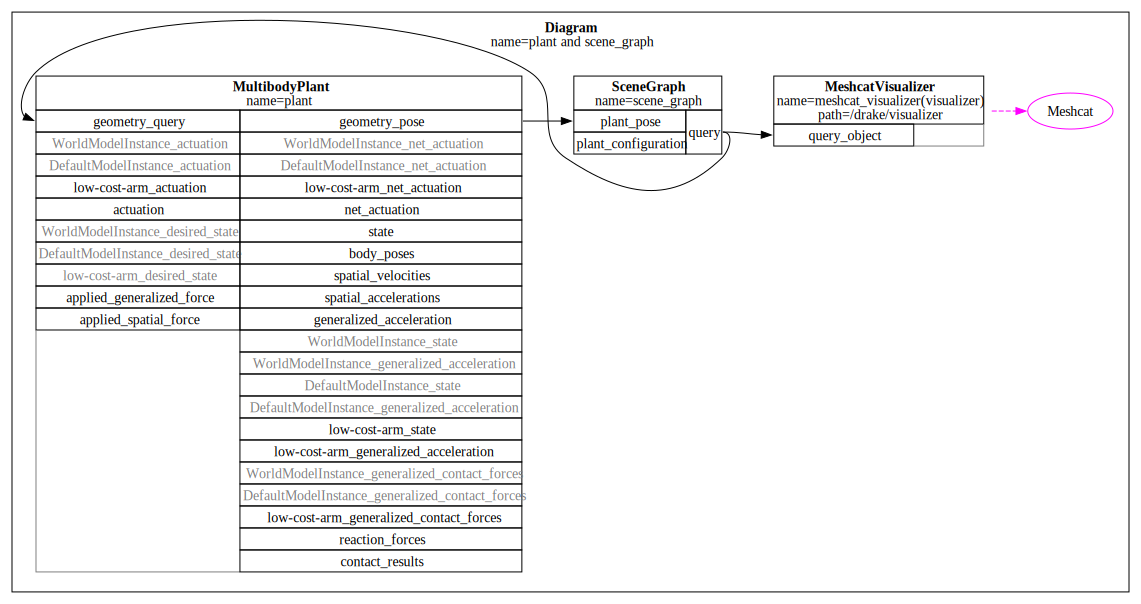

In [12]:
RenderDiagram(diagram)

In [13]:
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.GetPositions(plant_context)

array([0., 0., 0., 0., 0.])

In [14]:
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [0.5, 0, 0, 0, -1])
# plant.get_actuation_input_port().FixValue(plant_context, np.zeros(5)) # is this line doing anything for low cost robot?
# print(context)
print(plant.GetPositions(plant_context))

# re-render
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)
# RenderDiagram(diagram)

[ 0.5  0.   0.   0.  -1. ]


In [15]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)

In [16]:
def animation_demo():
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    Parser(plant, scene_graph).AddModelsFromUrl(
            "file:///Users/raghav/Documents/projects/robot_arm/low_cost_robot/drake_setup/low-cost-arm.urdf"
    )
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"))
    plant.Finalize()

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    print("Positions", plant.GetPositions(plant_context))
    plant.SetPositions(plant_context, [0, 0, 0, 0, 0])
    plant.get_actuation_input_port().FixValue(plant_context, np.zeros(5))

    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)

    # Record things if needed
    # meshcat.StartRecording()
    simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)
    # meshcat.StopRecording()
    # meshcat.PublishRecording()


animation_demo()


Positions [0. 0. 0. 0. 0.]


## Animation with Robot Sample Driver

In [17]:
# Control
builder = DiagramBuilder()
meshcat.DeleteRecording()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
robot_model = Parser(plant, scene_graph).AddModelsFromUrl(
        "file:///Users/raghav/Documents/projects/robot_arm/low_cost_robot/drake_setup/low-cost-arm.urdf"
)[0]
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
kp = [100] * plant.num_positions()
ki = [1] * plant.num_positions()
kd = [20] * plant.num_positions()
static_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
static_controller.set_name("static_controller")
builder.Connect(
    plant.get_state_output_port(robot_model),
    static_controller.get_input_port_estimated_state(),
)
builder.Connect(
    static_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()
diagram.set_name("with iiwa controller")

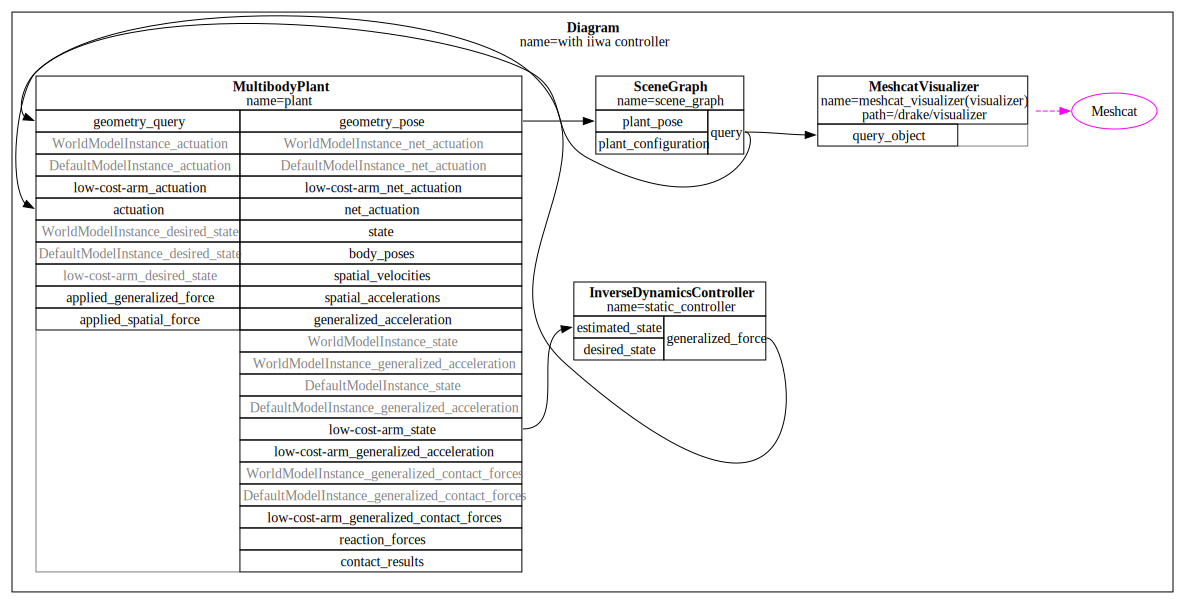

In [18]:
RenderDiagram(diagram, max_depth=1)

In [19]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([-1.57, 0.1, 0, -1.2, 0])
x0 = np.hstack((q0, 0 * q0))
plant.SetPositions(plant_context, q0)
static_controller.GetInputPort("desired_state").FixValue(
    static_controller.GetMyMutableContextFromRoot(context), x0
)
print(context)
plant.get_state_output_port(robot_model).Eval(plant_context)[:5]

::with iiwa controller Context (of a Diagram)
----------------------------------------------
5 total continuous states
10 total discrete states in 1 groups
150 total numeric parameters in 29 groups
8 total abstract parameters

::with iiwa controller::plant Context
--------------------------------------
Time: 0
States:
  1 discrete state groups with
     10 states
       -1.57   0.1     0  -1.2     0     0     0     0     0     0

Parameters:
  28 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
   

array([-1.57,  0.1 ,  0.  , -1.2 ,  0.  ])

In [20]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);

At this point, the robot should be stable. You can play around with `q0` below.

In [21]:
# play around with q0
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([0 , -np.pi / 2, 0, 0, -np.pi / 2])
x0 = np.hstack((q0, 0 * q0))
plant.SetPositions(plant_context, np.zeros(5))
static_controller.GetInputPort("desired_state").FixValue(
    static_controller.GetMyMutableContextFromRoot(context), x0
)
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(1.0)